In [1]:
import dataclasses as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def cat(*xs):
    return np.concatenate(xs)


@dc.dataclass
class Info:
    t: np.ndarray = None
    dt: np.ndarray = None
    q: np.ndarray = None
    dq: np.ndarray = None
    tau: np.ndarray = None
    tau_ext_filt: np.ndarray = None

    qd: np.ndarray = None
    dqd: np.ndarray = None

    qd_2: np.ndarray = None
    dqd_2: np.ndarray = None
        
    e: np.ndarray = None

    @staticmethod
    def from_csv(file):        
        info = Info()
        df = pd.read_csv(file, sep=r'\s*,\s*', engine='python')
        # time is only 1ms resolution :(
        ts = df['duration']
        info.t = (ts - ts[0]) / 1e3
        info.dt = cat([0.0], np.diff(info.t))
        info.q = df['q[3]']
        info.dq = df['dq[3]']
        info.tau = df['tau_J[3]']
        info.tau_ext_filt = df['tau_ext_hat_filtered[3]']
        # use loopback from robot_state, not the commanded... I think?
        info.qd = df['q_d[3]']
        info.dqd = df['dq_d[3]']
        info.qd_2 = df['q_d[3].1'].copy()
        info.qd_2[0] = info.qd_2[1]
        dt = 1e3
        info.dqd_2 = cat([0.0], np.diff(info.qd_2) / dt)
        # Compute error, actual - desired
        info.e = info.q - info.qd
        return info

In [3]:
data = {
    "delay_0": Info.from_csv("/home/eacousineau/data/panda/interp/delay_0.log"),
    "delay_1": Info.from_csv("/home/eacousineau/data/panda/interp/delay_1.log"),
    "delay_10": Info.from_csv("/home/eacousineau/data/panda/interp/delay_10.log"),
    "delay_100": Info.from_csv("/home/eacousineau/data/panda/interp/delay_100.log"),
    "delay_1000": Info.from_csv("/home/eacousineau/data/panda/interp/delay_1000.log"),
}

delay_0: n=4958
delay_1: n=4965
delay_10: n=4967
delay_100: n=4972
delay_1000: n=4969


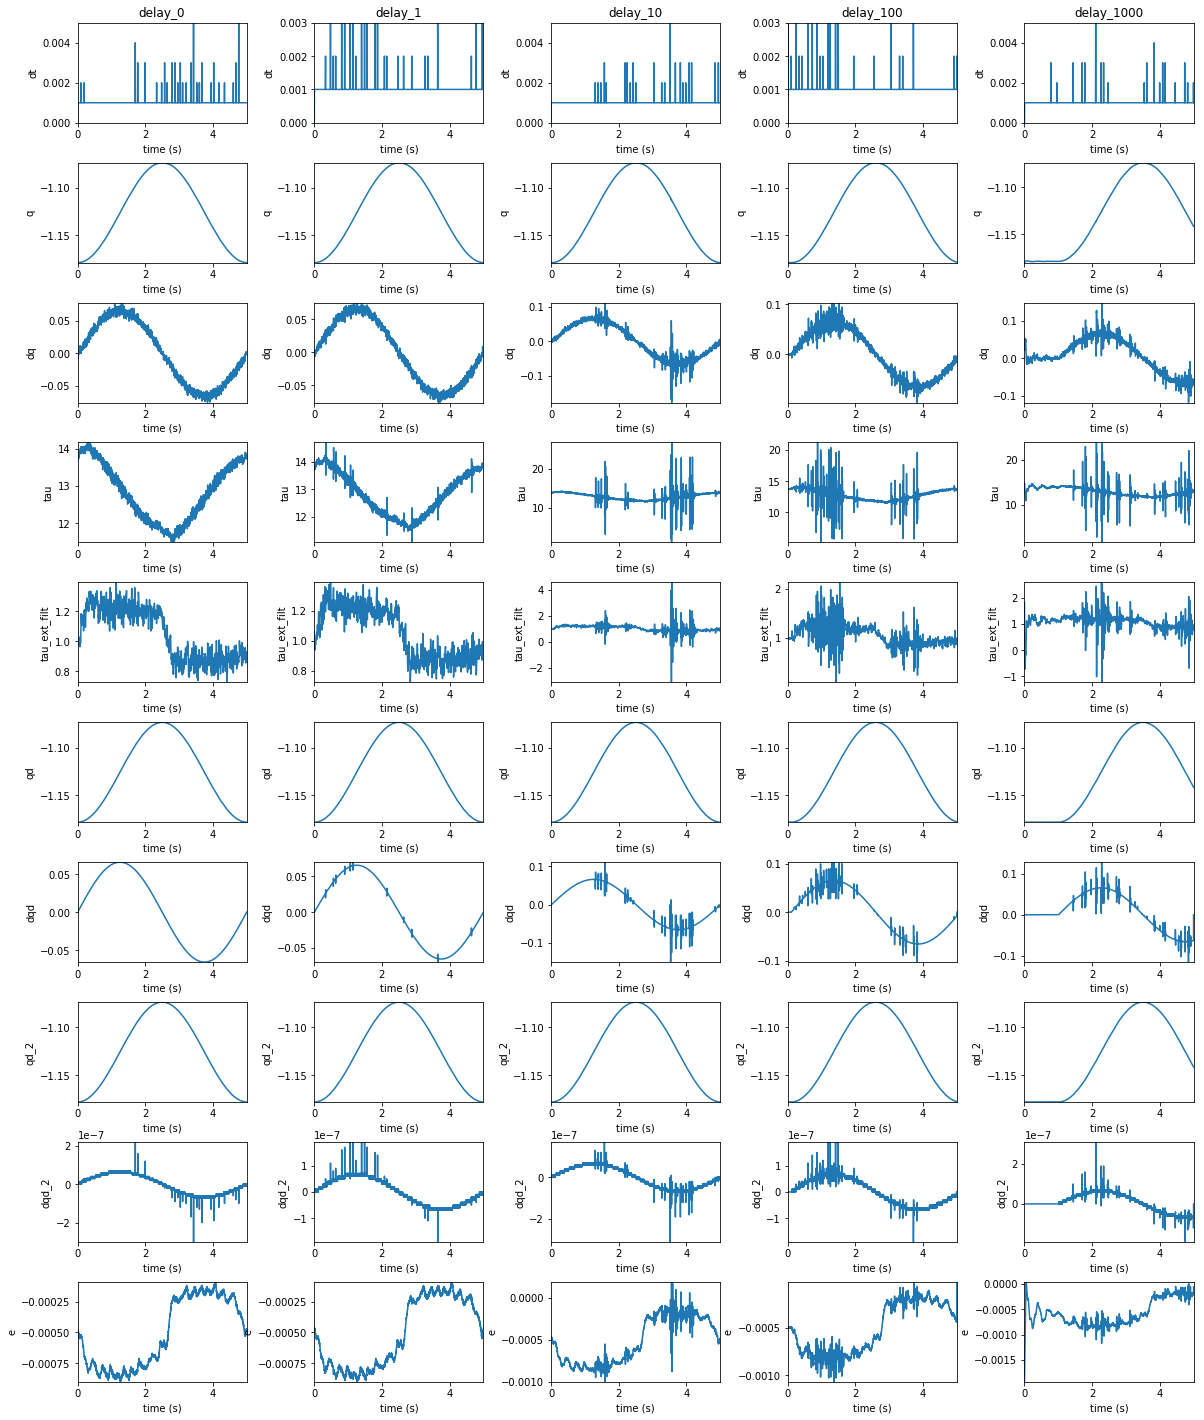

In [4]:
fields = dc.fields(Info)[1:]
N = len(fields)
_, axs = plt.subplots(nrows=N, ncols=len(data), figsize=(20, 25))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for c, (label, info) in enumerate(data.items()):
    print(f"{label}: n={len(info.t)}")
    for r, field in enumerate(fields):
        name = field.name
        value = getattr(info, name)
        ax = axs[r, c]
        plt.sca(ax)
        plt.plot(info.t, value)
        plt.ylabel(name)
        plt.xlabel('time (s)')
        ax.autoscale(tight=True)
        if r == 0:
            plt.title(label)